# RTF Model for predicting zone with Envelope

### Model Description
This notebook implements a Random Forest (RTF) model to classify the impact zone (C, S, V) of a racket based on the envelope of the audio signal. Each .wav file is processed to isolate a single audio channel, from which the temporal envelope is extracted using the Hilbert transform. This envelope captures the amplitude variation of the impact sound over time. The envelope is then downsampled or summarized (e.g., using mean values, max, or key segments) to create a fixed-length feature vector for each sample. These vectors are normalized and used to train a Random Forest classifier. The model's performance is evaluated using standard accuracy metrics across a range of hyperparameters. 

# Import Libraries

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import sys
from sklearn.ensemble import RandomForestClassifier


### Import Tools Functions

In [2]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

Readwav function

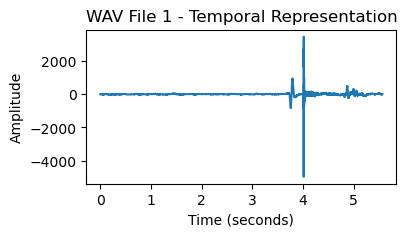

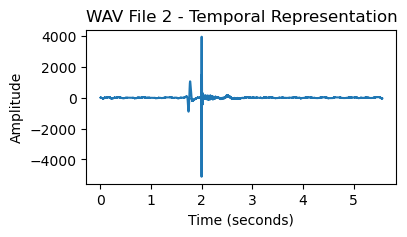

In [3]:
from readWavFolder import readWavFolder
    
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")

for i, wav_data in enumerate(testWavFileVect[:2]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 1])  # Plot only the n channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


Spectrum

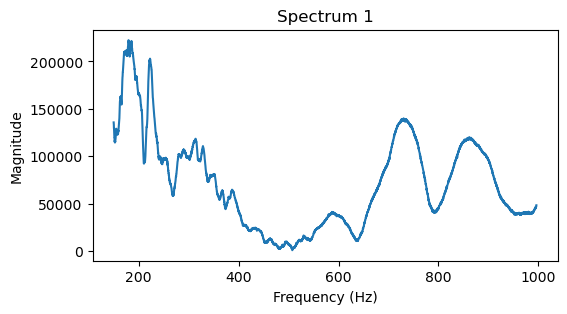

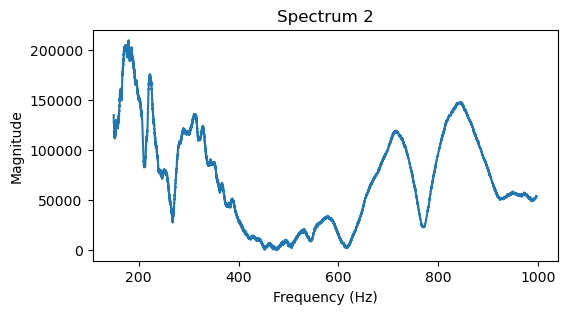

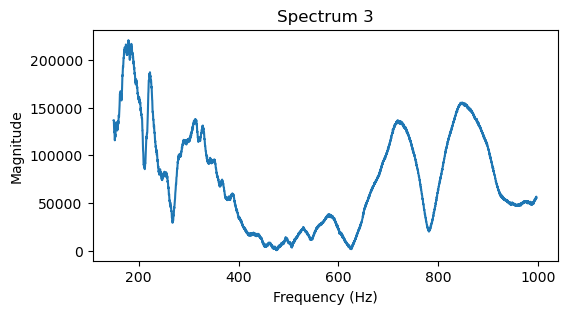

In [4]:
from spectrumFromSignal import spectrumFromSignal


spectrumVect=[]

for i in range(len(testWavFileVect)):
    spectrum,freqs= spectrumFromSignal(testWavFileVect[i],samplerateVect[i])
    spectrumVect.append(spectrum)

for idx, spectrum in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs[:len(spectrum)], spectrum)  # Associate frequencies with the spectrum
    plt.title(f"Spectrum {idx + 1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()



Envelope

In [5]:
from envelope_from_signal import envelope_from_signal

# Main

### Data Preparation and Label Encoding

In [6]:
import re
from readWavFolder import readWavFolder
from spectrumFromWav import spectrumFromWav

from readWavFolder import readWavFolder
from envelope_from_signal import envelope_from_signal

# Liste des types de raquettes et zones
racket_names = {"RB": 1, "RO": 2, "RR": 3, "RV": 4}
zone_names = {"C": 1, "S": 2, "V": 3}

results = []
c = 0  # Canal audio : 0 = gauche, 1 = droite

X_Envelope = []
Y_Label = []

for raquetteType in racket_names:
    dossier_raquette = f"../../../Data/Sound/P1"
    samplerateVect, WavFileVect, filesName = readWavFolder(dossier_raquette)

    for i in range(len(WavFileVect)):
        filename = filesName[i]

        # Extraire la zone depuis le nom du fichier
        match = re.search(r'_(C|S|V)_', filename)
        if match:
            zone = match.group(1)
        else:
            continue  # Fichier ignoré s'il ne contient pas une zone valide

        wav_data = WavFileVect[i]

        # Gérer mono/stéréo
        if wav_data.ndim == 1:
            wav_data = np.stack((wav_data, wav_data), axis=-1)
        elif wav_data.shape[1] == 1:
            wav_data = np.concatenate((wav_data, wav_data), axis=1)

        signal = wav_data[:, c]

        # Extraire l'enveloppe du signal
        envelope = envelope_from_signal(signal)

        # Option : downsampling (par ex. tous les 20 échantillons) pour réduire la taille
        downsampled_env = envelope[::20]

        X_Envelope.append(downsampled_env)
        Y_Label.append(zone)

# Normalisation
X_Envelope = [
    e / np.max(e) if np.max(e) != 0 else e
    for e in X_Envelope
]

# Padding pour égaliser la taille des vecteurs
max_length = max(len(e) for e in X_Envelope)
X_padded = [np.pad(e, (0, max_length - len(e)), constant_values=0) for e in X_Envelope]

X = np.array(X_padded)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y_Label)

# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Grille de recherche d’hyperparamètres
n_estimators_range = range(10, 101, 10)
max_depth_range = [None, 10, 20, 30, 40]
min_samples_split_range = [2, 5, 10]

for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)
            accuracy_train = accuracy_score(y_train, rf.predict(X_train))

            channel_name = "Left" if c == 0 else "Right"

            results.append({
                'Chanel_Name': channel_name,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Export des résultats
results_df = pd.DataFrame(results)
# results_df.to_excel("RTF_ZONE_P1_Envelope.xlsx", index=False)
print("DONE")

DONE


## Results and Visualisation

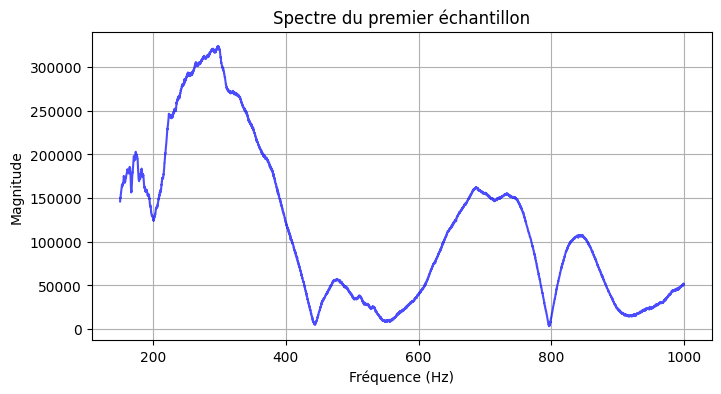

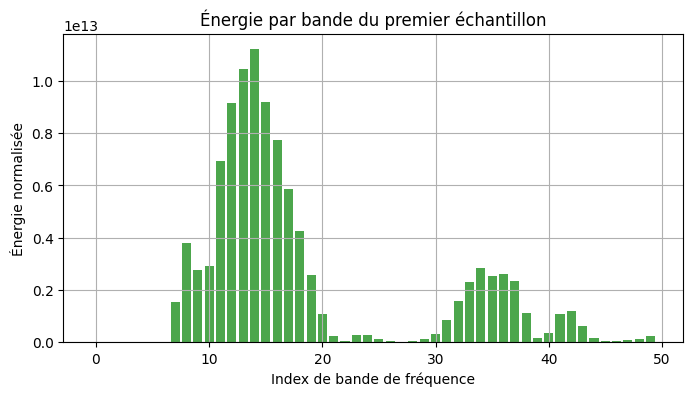

In [ ]:
# Afficher le spectre du premier échantillon
plt.figure(figsize=(8, 4))
plt.plot(filtered_freqs, np.abs(filtered_spectrum), color='blue', alpha=0.7)
plt.title("Spectre du premier échantillon")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()



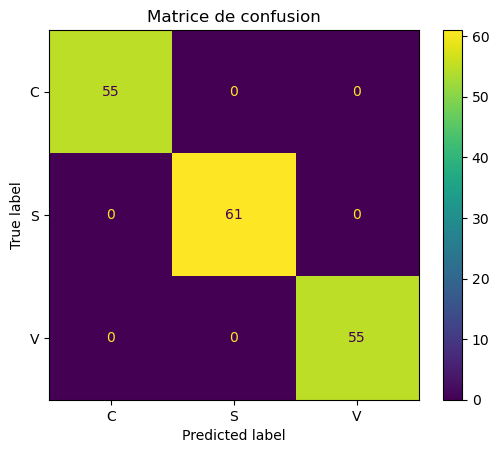

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
